# Viewer with dask delay

This notebook is for segmenting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [124]:
import napari
import cellpose
from octopuslite import utils, tile

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = '3'
column = '7'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
images = tile.compile_mosaic(image_dir, metadata, row, column, )
images

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

,Array,Chunk
Bytes,30.66 GiB,46.51 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 2016, 2016)"
Count,13500 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [6]:
images = tile.compile_mosaic(image_dir, metadata, row, column, set_plane= 2, set_channel=2, set_time=73)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
images

dask.array<reshape, shape=(1, 1, 1, 6048, 6048), dtype=uint16, chunksize=(1, 1, 1, 2016, 2016), chunktype=numpy.ndarray>

# Only compile subset of whole image

# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [ ]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img):
    masks, flows, styles, diams = model.eval(img, diameter=200, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

In [10]:
import os
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict, Union, Optional, Callable
ArrayLike = Union[
    np.ndarray, "dask.array.Array"
]
import dask
import dask.array as da
from functools import partial
from pathlib import Path
FilePath = Union[Path, str]
from tqdm.auto import tqdm

In [12]:
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)

In [11]:
def load_image(
    file: FilePath, transforms: List[Callable[[ArrayLike], ArrayLike]] = None
) -> np.ndarray:
    img = imread(file)
    # if img.ndim == 2:
    #    img = np.expand_dims(img, axis=0)
    if transforms is not None:
        for t in transforms:
            img = t(img)
    return img

In [8]:
input_transforms = None

In [13]:
image_directory = image_dir

In [14]:
set_time = 0
set_channel = 1
set_plane = 1

In [16]:
channel_IDs = (metadata['ChannelID'].unique() 
               if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique() 
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique() 
             if set_time == None else [set_time])

In [24]:
channel_IDs = metadata['ChannelID'].unique() 
              
plane_IDs = metadata['PlaneID'].unique() 
             
timepoint_IDs = metadata['TimepointID'].unique() 
             

trying to both make it so that only a single slice can be tiled and also to do in a dask delayed manner

In [17]:
from tqdm.auto import tqdm

In [61]:
### stitch the images together over all defined axis
images = [tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    for plane in tqdm(plane_IDs, leave = False)
                for channel in tqdm(channel_IDs, leave = False)
                for time in tqdm(timepoint_IDs, leave = False)]
### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]


KeyboardInterrupt



# now try dask delayed

In [19]:
import dask.array as da
import dask

In [21]:
col = column

In [29]:
import numpy as np

In [32]:
time, plane, channel = 1, 1, 1

In [34]:
dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False).compute()

(dask.array<fuse_func, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>,
  <shapely.geometry.polygon.Polygon at 0x7f5c4611bdc0>])

In [30]:
### stitch the images together over all defined axis
images = [da.from_delayed(
          dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False),
                    shape = (6048, 6048), 
                    dtype = np.uint16
                    )[0]
                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### stack them together
images = da.stack(images, axis = 0)
### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

ValueError: total size of new array must be unchanged

In [121]:
### stitch the images together over all defined axis 
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    
                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048), 
                dtype = np.uint16)
                for frame in images]
### rechunk so they are more managable 
images = [frame.rechunk(2016,2016) for frame in images]
### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [119]:
from skimage.io import imshow, imread

In [118]:
images[0,0,0].compute()

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


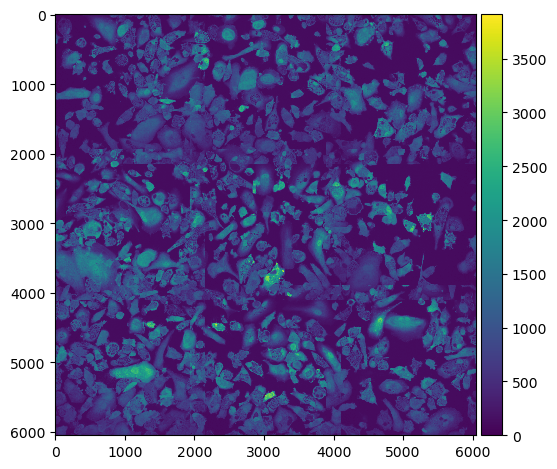

In [122]:
imshow(images[0,0,0].compute())

# Note: think some of the dimensionality may have gotten muddled, with channels appearing swapped at times...


In [123]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
# viewer.add_labels(mask_images, 
#                  )

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'macrophage' at 0x7f5c5e90d670>,
 <Image layer 'mtb' at 0x7f5c363f2ca0>]

In [58]:
images = da.stack([tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    for plane in plane_IDs
                    for channel in channel_IDs
                    for time in timepoint_IDs], 
                    axis = 0)

images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

# Troubleshooting mismatched dimensions

Firstly checking over all channels and planes and time

In [131]:
set_channel = None
set_plane = None
set_time = None

In [134]:
# image_directory: os.PathLike,
# metadata: pd.DataFrame,
# row: int,
# col: int,
# input_transforms: List[Callable[[ArrayLike], ArrayLike]] = None,
# set_plane = None,
# set_channel = None,
# set_time = None
# )->dask.array:

### extract some necessary information from the metadata before tiling
channel_IDs = (metadata['ChannelID'].unique()
           if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique()
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique()
             if set_time == None else [set_time])
### set a few parameters for the tiling approach
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]

                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16)
                for frame in images]
# ### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
# ### stack them together
# images = da.stack(images, axis = 0)
# # ### reshape them according to TCZXY
# images = images.reshape((len(timepoint_IDs),
#                          len(channel_IDs),
#                          len(plane_IDs),
#                          images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

### The dimensions are seemingly ordered correcty...

In [137]:
plane_IDs

array(['1', '2', '3'], dtype=object)

In [138]:
channel_IDs

array(['1', '2'], dtype=object)

In [139]:
timepoint_IDs

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74'], dtype=object)

### Which means that the following image should be a compilation featuring...

In [144]:
import glob

In [141]:
row, col, channel, time

('3', '7', 1, 1)

In [146]:
files = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}f0*p01-ch{channel}sk{time}fk1fl1.tiff'))
glob.glob(os.path.join(image_dir, f'r0{row}c0{col}f0*p01-ch{channel}sk{time}fk1fl1.tiff'))

['/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f05p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f02p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f09p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f06p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f03p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f08p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f07p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f04p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f01p01-ch1sk1fk1fl1

#### Manually creating first frame

In [149]:
df = metadata

In [ ]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [150]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


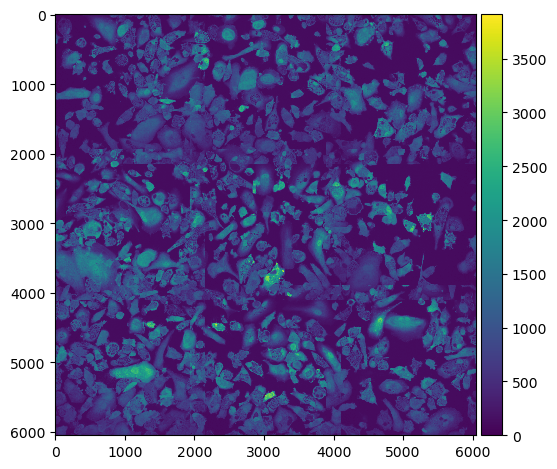

In [154]:
imshow(images[0])

In [168]:
frame[0].compute().astype(np.uint8)

array([[129, 130, 131, ..., 173, 174,   0],
       [135, 134, 132, ..., 184, 181,   0],
       [143, 137, 142, ..., 176, 174,   0],
       ...,
       [242,   9, 245, ..., 110, 109,   0],
       [249,  16, 249, ..., 113, 107,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


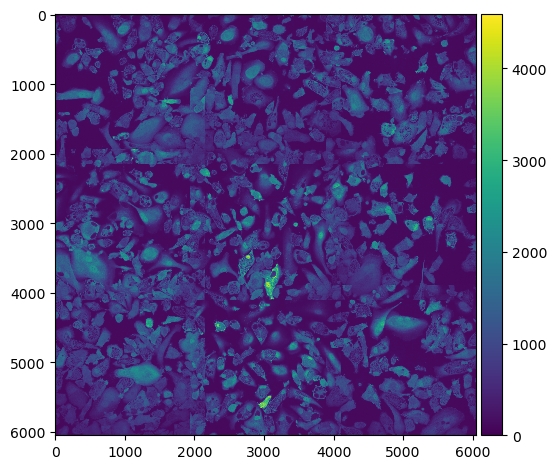

In [157]:
imshow(frame[0])

In [160]:
import matplotlib.pyplot as plt

In [178]:
import napari

In [184]:
f = frame[0].compute()

In [190]:
i = images[0].compute().compute()

In [192]:
i

array([[186, 195, 187, ..., 110, 102,   0],
       [182, 178, 173, ..., 114, 104,   0],
       [165, 169, 182, ..., 112, 112,   0],
       ...,
       [278, 281, 272, ..., 101, 100,   0],
       [277, 282, 273, ..., 107, 100,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


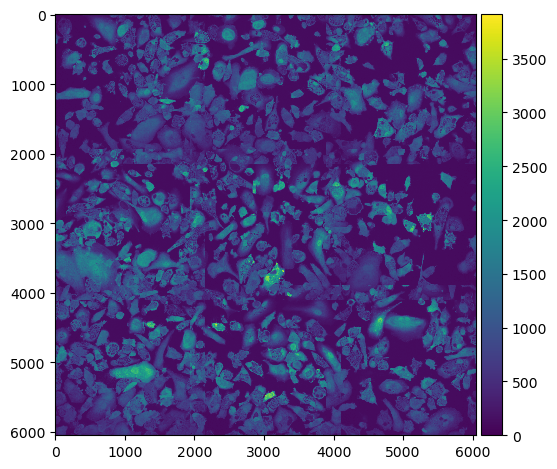

In [196]:
imshow(i)

In [198]:
f.shape

(6048, 6048)

In [199]:
i.shape

(6048, 6048)

In [200]:
import napari

In [202]:
v = napari.Viewer()

v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c562990d0>

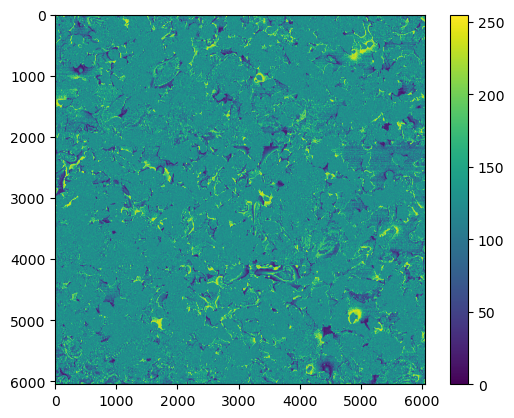

In [171]:
plt.imshow(images[0].compute().astype(np.uint8) - frame[0].compute().astype(np.uint8))
plt.colorbar()
plt.savefig('/home/dayn/Pictures/for_grace/grace_shirt_1.png', dpi = 314, bbox_inches = 'tight')

# These two images appear to be one temporal neighbours
just checking the next plane up

In [205]:
plane_IDs

array(['1', '2', '3'], dtype=object)

In [206]:
plane

1

In [207]:
files = glob.glob(os.path.join(image_dir, f'r0{row}c0{col}f0*p01-ch{channel}sk{time}fk1fl1.tiff'))
glob.glob(os.path.join(image_dir, f'r0{row}c0{col}f0*p0{plane}-ch{channel}sk{time}fk1fl1.tiff'))

['/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f05p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f02p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f09p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f06p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f03p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f08p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f07p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f04p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c07f01p01-ch1sk1fk1fl1

#### Manually creating first frame

In [208]:
df = metadata

In [209]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [210]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [211]:
f = frame[0].compute()

In [212]:
i = images[0].compute().compute()

In [213]:
v = napari.Viewer()

v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c58854af0>

# testing one slice

In [220]:
set_channel = 2
set_plane = 2
set_time = 0

channel = 2
plane = 2
time = 2

In [215]:
# image_directory: os.PathLike,
# metadata: pd.DataFrame,
# row: int,
# col: int,
# input_transforms: List[Callable[[ArrayLike], ArrayLike]] = None,
# set_plane = None,
# set_channel = None,
# set_time = None
# )->dask.array:

### extract some necessary information from the metadata before tiling
channel_IDs = (metadata['ChannelID'].unique()
           if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique()
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique()
             if set_time == None else [set_time])
### set a few parameters for the tiling approach
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]

                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16)
                for frame in images]
# ### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
# ### stack them together
# images = da.stack(images, axis = 0)
# # ### reshape them according to TCZXY
# images = images.reshape((len(timepoint_IDs),
#                          len(channel_IDs),
#                          len(plane_IDs),
#                          images.shape[-2], images.shape[-1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [216]:
images[0]

[dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>]

In [218]:
i = images[0].compute()

#### Manually creating corresponding frame

In [227]:
set_channel = 2
set_plane = 2
set_time = 0

channel = 2
plane = 2
time = 0

In [230]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [231]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
219,0307K1F1P2R2,Ok,r03c07f01p02-ch2sk1fk1fl1.tiff,3,7,1,2,0,2,1,...,2E-06,0.135615095,0,2021-04-16T19:13:03.643+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
225,0307K1F2P2R2,Ok,r03c07f02p02-ch2sk1fk1fl1.tiff,3,7,2,2,0,2,1,...,2E-06,0.135613203,0,2021-04-16T19:13:04.923+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
231,0307K1F3P2R2,Ok,r03c07f03p02-ch2sk1fk1fl1.tiff,3,7,3,2,0,2,1,...,2E-06,0.135612398,0,2021-04-16T19:13:06.217+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
237,0307K1F4P2R2,Ok,r03c07f04p02-ch2sk1fk1fl1.tiff,3,7,4,2,0,2,1,...,2E-06,0.135611907,0,2021-04-16T19:13:07.933+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
243,0307K1F5P2R2,Ok,r03c07f05p02-ch2sk1fk1fl1.tiff,3,7,5,2,0,2,1,...,2E-06,0.135613501,0,2021-04-16T19:13:09.23+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
249,0307K1F6P2R2,Ok,r03c07f06p02-ch2sk1fk1fl1.tiff,3,7,6,2,0,2,1,...,2E-06,0.135613993,0,2021-04-16T19:13:10.523+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
255,0307K1F7P2R2,Ok,r03c07f07p02-ch2sk1fk1fl1.tiff,3,7,7,2,0,2,1,...,2E-06,0.135614395,0,2021-04-16T19:13:11.803+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
261,0307K1F8P2R2,Ok,r03c07f08p02-ch2sk1fk1fl1.tiff,3,7,8,2,0,2,1,...,2E-06,0.135615006,0,2021-04-16T19:13:13.097+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
267,0307K1F9P2R2,Ok,r03c07f09p02-ch2sk1fk1fl1.tiff,3,7,9,2,0,2,1,...,2E-06,0.135613903,0,2021-04-16T19:13:14.55+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [232]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [233]:
f = frame[0].compute()

In [234]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c59c2ed60>

# that worked, the two frames are correct

So the single frame extraction tool works seemingly correctly...

does this mean its the way the images are ordered after tiling that causes issues?

first another quick test

# testing one slice

In [249]:
set_channel = 1
set_plane = 1
set_time = 0

channel = 1
plane = 1
time = 0

In [250]:
# image_directory: os.PathLike,
# metadata: pd.DataFrame,
# row: int,
# col: int,
# input_transforms: List[Callable[[ArrayLike], ArrayLike]] = None,
# set_plane = None,
# set_channel = None,
# set_time = None
# )->dask.array:

### extract some necessary information from the metadata before tiling
channel_IDs = (metadata['ChannelID'].unique()
           if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique()
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique()
             if set_time == None else [set_time])
### set a few parameters for the tiling approach
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]

                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16)
                for frame in images]
# ### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
# ### stack them together
# images = da.stack(images, axis = 0)
# # ### reshape them according to TCZXY
# images = images.reshape((len(timepoint_IDs),
#                          len(channel_IDs),
#                          len(plane_IDs),
#                          images.shape[-2], images.shape[-1]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [251]:
images[0]

dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>

In [252]:
i = images[0].compute()

#### Manually creating corresponding frame

In [253]:
set_channel = 1
set_plane = 1
set_time = 0

channel = 1
plane = 1
time = 0

In [254]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [255]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
216,0307K1F1P1R1,Ok,r03c07f01p01-ch1sk1fk1fl1.tiff,3,7,1,1,0,1,1,...,0,0.135613099,0,2021-04-16T19:13:03.363+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
222,0307K1F2P1R1,Ok,r03c07f02p01-ch1sk1fk1fl1.tiff,3,7,2,1,0,1,1,...,0,0.135611296,0,2021-04-16T19:13:04.643+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
228,0307K1F3P1R1,Ok,r03c07f03p01-ch1sk1fk1fl1.tiff,3,7,3,1,0,1,1,...,0,0.135610297,0,2021-04-16T19:13:05.937+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
234,0307K1F4P1R1,Ok,r03c07f04p01-ch1sk1fk1fl1.tiff,3,7,4,1,0,1,1,...,0,0.135609895,0,2021-04-16T19:13:07.653+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
240,0307K1F5P1R1,Ok,r03c07f05p01-ch1sk1fk1fl1.tiff,3,7,5,1,0,1,1,...,0,0.135611504,0,2021-04-16T19:13:08.947+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
246,0307K1F6P1R1,Ok,r03c07f06p01-ch1sk1fk1fl1.tiff,3,7,6,1,0,1,1,...,0,0.135611996,0,2021-04-16T19:13:10.243+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
252,0307K1F7P1R1,Ok,r03c07f07p01-ch1sk1fk1fl1.tiff,3,7,7,1,0,1,1,...,0,0.135612398,0,2021-04-16T19:13:11.507+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
258,0307K1F8P1R1,Ok,r03c07f08p01-ch1sk1fk1fl1.tiff,3,7,8,1,0,1,1,...,0,0.135612994,0,2021-04-16T19:13:12.817+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
264,0307K1F9P1R1,Ok,r03c07f09p01-ch1sk1fk1fl1.tiff,3,7,9,1,0,1,1,...,0,0.135611996,0,2021-04-16T19:13:14.267+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [256]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [258]:
f = frame[0].compute()

In [259]:
i = images[0].compute()

In [261]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c5f782460>

### p sure it works for single frames, so lets test the compilation over the whole stack

# testing whole stack 

To see if the later steps mess up the order of compilation 

In [262]:
set_channel = None
set_plane = None
set_time = None

channel = 1
plane = 1
time = 0

In [263]:
# image_directory: os.PathLike,
# metadata: pd.DataFrame,
# row: int,
# col: int,
# input_transforms: List[Callable[[ArrayLike], ArrayLike]] = None,
# set_plane = None,
# set_channel = None,
# set_time = None
# )->dask.array:

### extract some necessary information from the metadata before tiling
channel_IDs = (metadata['ChannelID'].unique()
           if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique()
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique()
             if set_time == None else [set_time])
### set a few parameters for the tiling approach
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]

                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16)
                for frame in images]
# ### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
# ### stack them together
# images = da.stack(images, axis = 0)
# # ### reshape them according to TCZXY
# images = images.reshape((len(timepoint_IDs),
#                          len(channel_IDs),
#                          len(plane_IDs),
#                          images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [264]:
images

[dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(6048, 6048), dtype=uint16, chunksize=(6048, 6048), chunktype=numpy.ndarray>,
 dask.array<from-value, shap

In [265]:
i = images[0].compute()

#### Manually creating corresponding frame for what i assume to be the first time, plkane and channel in a list of dask arrays 

In [266]:
channel = 1
plane = 1
time = 0

In [267]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [268]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
216,0307K1F1P1R1,Ok,r03c07f01p01-ch1sk1fk1fl1.tiff,3,7,1,1,0,1,1,...,0,0.135613099,0,2021-04-16T19:13:03.363+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
222,0307K1F2P1R1,Ok,r03c07f02p01-ch1sk1fk1fl1.tiff,3,7,2,1,0,1,1,...,0,0.135611296,0,2021-04-16T19:13:04.643+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
228,0307K1F3P1R1,Ok,r03c07f03p01-ch1sk1fk1fl1.tiff,3,7,3,1,0,1,1,...,0,0.135610297,0,2021-04-16T19:13:05.937+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
234,0307K1F4P1R1,Ok,r03c07f04p01-ch1sk1fk1fl1.tiff,3,7,4,1,0,1,1,...,0,0.135609895,0,2021-04-16T19:13:07.653+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
240,0307K1F5P1R1,Ok,r03c07f05p01-ch1sk1fk1fl1.tiff,3,7,5,1,0,1,1,...,0,0.135611504,0,2021-04-16T19:13:08.947+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
246,0307K1F6P1R1,Ok,r03c07f06p01-ch1sk1fk1fl1.tiff,3,7,6,1,0,1,1,...,0,0.135611996,0,2021-04-16T19:13:10.243+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
252,0307K1F7P1R1,Ok,r03c07f07p01-ch1sk1fk1fl1.tiff,3,7,7,1,0,1,1,...,0,0.135612398,0,2021-04-16T19:13:11.507+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
258,0307K1F8P1R1,Ok,r03c07f08p01-ch1sk1fk1fl1.tiff,3,7,8,1,0,1,1,...,0,0.135612994,0,2021-04-16T19:13:12.817+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
264,0307K1F9P1R1,Ok,r03c07f09p01-ch1sk1fk1fl1.tiff,3,7,9,1,0,1,1,...,0,0.135611996,0,2021-04-16T19:13:14.267+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [269]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [270]:
f = frame[0].compute()

In [271]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c61ad3460>

### seems to have worked well for the first slice... testing the latter ones

In [272]:
i = images[1]

#### Manually creating corresponding frame for what i assume to be the first time, plkane and channel in a list of dask arrays 

In [273]:
channel = 1
plane = 1
time = 1

In [274]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [275]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
1728,0307K2F1P1R1,Ok,r03c07f01p01-ch1sk2fk1fl1.tiff,3,7,1,1,1,1,1,...,0,0.135617599,3597.007,2021-04-16T20:13:00.37+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1734,0307K2F2P1R1,Ok,r03c07f02p01-ch1sk2fk1fl1.tiff,3,7,2,1,1,1,1,...,0,0.135614201,3597.007,2021-04-16T20:13:01.667+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1740,0307K2F3P1R1,Ok,r03c07f03p01-ch1sk2fk1fl1.tiff,3,7,3,1,1,1,1,...,0,0.135613203,3597.007,2021-04-16T20:13:03.397+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1746,0307K2F4P1R1,Ok,r03c07f04p01-ch1sk2fk1fl1.tiff,3,7,4,1,1,1,1,...,0,0.135612696,3597.007,2021-04-16T20:13:05.067+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1752,0307K2F5P1R1,Ok,r03c07f05p01-ch1sk2fk1fl1.tiff,3,7,5,1,1,1,1,...,0,0.135615706,3597.007,2021-04-16T20:13:06.36+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1758,0307K2F6P1R1,Ok,r03c07f06p01-ch1sk2fk1fl1.tiff,3,7,6,1,1,1,1,...,0,0.135616004,3597.007,2021-04-16T20:13:07.703+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1764,0307K2F7P1R1,Ok,r03c07f07p01-ch1sk2fk1fl1.tiff,3,7,7,1,1,1,1,...,0,0.1356159,3597.007,2021-04-16T20:13:09.09+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1770,0307K2F8P1R1,Ok,r03c07f08p01-ch1sk2fk1fl1.tiff,3,7,8,1,1,1,1,...,0,0.135617495,3597.007,2021-04-16T20:13:10.403+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1776,0307K2F9P1R1,Ok,r03c07f09p01-ch1sk2fk1fl1.tiff,3,7,9,1,1,1,1,...,0,0.135616094,3597.007,2021-04-16T20:13:11.93+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [276]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [277]:
f = frame[0].compute()

In [279]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c62ac3490>

### works for t = 1, now testing other time frames then should be channel according to tczxy

In [280]:
i = images[2]

#### Manually creating corresponding frame for what i assume to be the first time, plkane and channel in a list of dask arrays 

In [281]:
channel = 1
plane = 1
time = 2

In [282]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [283]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
3240,0307K3F1P1R1,Ok,r03c07f01p01-ch1sk3fk1fl1.tiff,3,7,1,1,2,1,1,...,0,0.135616601,7199.6939999999995,2021-04-16T21:13:03.057+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3246,0307K3F2P1R1,Ok,r03c07f02p01-ch1sk3fk1fl1.tiff,3,7,2,1,2,1,1,...,0,0.135615006,7199.6939999999995,2021-04-16T21:13:04.383+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3252,0307K3F3P1R1,Ok,r03c07f03p01-ch1sk3fk1fl1.tiff,3,7,3,1,2,1,1,...,0,0.135614902,7199.6939999999995,2021-04-16T21:13:05.99+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3258,0307K3F4P1R1,Ok,r03c07f04p01-ch1sk3fk1fl1.tiff,3,7,4,1,2,1,1,...,0,0.135614306,7199.6939999999995,2021-04-16T21:13:07.643+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3264,0307K3F5P1R1,Ok,r03c07f05p01-ch1sk3fk1fl1.tiff,3,7,5,1,2,1,1,...,0,0.1356159,7199.6939999999995,2021-04-16T21:13:08.953+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3270,0307K3F6P1R1,Ok,r03c07f06p01-ch1sk3fk1fl1.tiff,3,7,6,1,2,1,1,...,0,0.135616407,7199.6939999999995,2021-04-16T21:13:10.297+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3276,0307K3F7P1R1,Ok,r03c07f07p01-ch1sk3fk1fl1.tiff,3,7,7,1,2,1,1,...,0,0.135616407,7199.6939999999995,2021-04-16T21:13:11.807+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3282,0307K3F8P1R1,Ok,r03c07f08p01-ch1sk3fk1fl1.tiff,3,7,8,1,2,1,1,...,0,0.135618106,7199.6939999999995,2021-04-16T21:13:13.133+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3288,0307K3F9P1R1,Ok,r03c07f09p01-ch1sk3fk1fl1.tiff,3,7,9,1,2,1,1,...,0,0.135616794,7199.6939999999995,2021-04-16T21:13:14.447+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [284]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [285]:
f = frame[0].compute()

In [287]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c662ca130>

### works for t = 1, now testing other time frames then should be channel according to tczxy

In [288]:
i = images[75]
### this should be the first rfp channel

#### Manually creating corresponding frame for what i assume to be the first time, plkane and channel in a list of dask arrays 

In [289]:
channel = 2
plane = 1
time = 0

In [290]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [291]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
217,0307K1F1P1R2,Ok,r03c07f01p01-ch2sk1fk1fl1.tiff,3,7,1,1,0,2,1,...,0,0.135613099,0,2021-04-16T19:13:03.363+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
223,0307K1F2P1R2,Ok,r03c07f02p01-ch2sk1fk1fl1.tiff,3,7,2,1,0,2,1,...,0,0.135611296,0,2021-04-16T19:13:04.643+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
229,0307K1F3P1R2,Ok,r03c07f03p01-ch2sk1fk1fl1.tiff,3,7,3,1,0,2,1,...,0,0.135610297,0,2021-04-16T19:13:05.937+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
235,0307K1F4P1R2,Ok,r03c07f04p01-ch2sk1fk1fl1.tiff,3,7,4,1,0,2,1,...,0,0.135609895,0,2021-04-16T19:13:07.653+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
241,0307K1F5P1R2,Ok,r03c07f05p01-ch2sk1fk1fl1.tiff,3,7,5,1,0,2,1,...,0,0.135611504,0,2021-04-16T19:13:08.947+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
247,0307K1F6P1R2,Ok,r03c07f06p01-ch2sk1fk1fl1.tiff,3,7,6,1,0,2,1,...,0,0.135611996,0,2021-04-16T19:13:10.243+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
253,0307K1F7P1R2,Ok,r03c07f07p01-ch2sk1fk1fl1.tiff,3,7,7,1,0,2,1,...,0,0.135612398,0,2021-04-16T19:13:11.523+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
259,0307K1F8P1R2,Ok,r03c07f08p01-ch2sk1fk1fl1.tiff,3,7,8,1,0,2,1,...,0,0.135612994,0,2021-04-16T19:13:12.817+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
265,0307K1F9P1R2,Ok,r03c07f09p01-ch2sk1fk1fl1.tiff,3,7,9,1,0,2,1,...,0,0.135611996,0,2021-04-16T19:13:14.267+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [292]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [293]:
f = frame[0].compute()

In [295]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c686a39d0>

### looking good, now check that there are different planes

0-74 = ch1 pl1
75-149 = ch2 pl1
150-224 = ch1 pl2
225-299 = ch2 pl2
300-374 = ch1 pl3
375-449 = ch2pl3

In [298]:
i = images[300]

#### Manually creating corresponding frame for what i assume to be the first time, plkane and channel in a list of dask arrays 

In [299]:
channel = 1
plane = 3
time = 0

In [300]:
filtered_df = df[(df['TimepointID'] == str(time))
                   &(df['PlaneID'] == str(plane))
                   &(df['ChannelID'] == str(channel))
                   &(df['Row'] == str(row))
                   &(df['Col'] == str(col))
                    ]

In [301]:
filtered_df

,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
220,0307K1F1P3R1,Ok,r03c07f01p03-ch1sk1fk1fl1.tiff,3,7,1,3,0,1,1,...,4E-06,0.135617107,0,2021-04-16T19:13:03.91+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
226,0307K1F2P3R1,Ok,r03c07f02p03-ch1sk1fk1fl1.tiff,3,7,2,3,0,1,1,...,4E-06,0.1356152,0,2021-04-16T19:13:05.203+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
232,0307K1F3P3R1,Ok,r03c07f03p03-ch1sk1fk1fl1.tiff,3,7,3,3,0,1,1,...,4E-06,0.135614395,0,2021-04-16T19:13:06.5+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
238,0307K1F4P3R1,Ok,r03c07f04p03-ch1sk1fk1fl1.tiff,3,7,4,3,0,1,1,...,4E-06,0.135613903,0,2021-04-16T19:13:08.217+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
244,0307K1F5P3R1,Ok,r03c07f05p03-ch1sk1fk1fl1.tiff,3,7,5,3,0,1,1,...,4E-06,0.135615498,0,2021-04-16T19:13:09.493+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
250,0307K1F6P3R1,Ok,r03c07f06p03-ch1sk1fk1fl1.tiff,3,7,6,3,0,1,1,...,4E-06,0.135616004,0,2021-04-16T19:13:10.79+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
256,0307K1F7P3R1,Ok,r03c07f07p03-ch1sk1fk1fl1.tiff,3,7,7,3,0,1,1,...,4E-06,0.135616407,0,2021-04-16T19:13:12.067+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
262,0307K1F8P3R1,Ok,r03c07f08p03-ch1sk1fk1fl1.tiff,3,7,8,3,0,1,1,...,4E-06,0.135617003,0,2021-04-16T19:13:13.363+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
268,0307K1F9P3R1,Ok,r03c07f09p03-ch1sk1fk1fl1.tiff,3,7,9,3,0,1,1,...,4E-06,0.135616004,0,2021-04-16T19:13:14.83+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [302]:
frame = tile.stitch(load_transform_image, 
                   metadata, 
                   image_dir, 
                   time, 
                   plane, 
                   channel, 
                   row, 
                   col, 
                   chunk_fraction = 9, 
                   mask = False)

In [303]:
f = frame[0].compute()

In [305]:
v = napari.Viewer()
v.add_image(i)
v.add_image(f)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'f' at 0x7f5c6b458460>

### okay that works... so is there a muddling of things after the list of stitched images has been reordered

In [308]:
### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
### stack them together
image_stack = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images_reshape = image_stack.reshape((len(timepoint_IDs),
                         len(channel_IDs),
                         len(plane_IDs),
                         image_stack.shape[-2], image_stack.shape[-1]))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3134: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Checking general order of stack after stacking together

should be 75 gfp frames, then 75 rfp frames, followed by the same in the next z plane et6c etc

``0-74 = ch1 pl1
75-149 = ch2 pl1
150-224 = ch1 pl2
225-299 = ch2 pl2
300-374 = ch1 pl3
375-449 = ch2pl3``

In [314]:
v = napari.Viewer()
v.add_image(image_stack)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'image_stack' at 0x7f5c6eddc0a0>

###  image_stack looks to be in the correct order

In [327]:
image_stack

dask.array<stack, shape=(450, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>

In [312]:
images_reshape

,Array,Chunk
Bytes,30.66 GiB,418.61 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 6048, 6048)"
Count,1950 Tasks,75 Chunks
Type,uint16,numpy.ndarray


In [313]:
v = napari.Viewer()
v.add_image(images_reshape)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'images_reshape' at 0x7f5c38a96fd0>

# reshaping the stack like this screws things up


In [315]:
image_stack

dask.array<stack, shape=(450, 6048, 6048), dtype=uint16, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>

In [320]:
reshape = image_stack.reshape((75, 3, 2, 6048, 6048))
v = napari.Viewer()
v.add_image(reshape)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3134: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requir

<Image layer 'reshape' at 0x7f5c6ea096d0>

In [331]:
%%time
image_stack_loaded = image_stack.compute()

CPU times: user 1min 52s, sys: 2.85 s, total: 1min 55s
Wall time: 58.9 s


In [333]:
type(image_stack_loaded)

dask.array.core.Array

In [334]:
%%time
image_stack_loaded = image_stack_loaded.compute()

CPU times: user 3h 40min 48s, sys: 8min 47s, total: 3h 49min 36s
Wall time: 8min 8s


In [336]:
v = napari.Viewer()
v.add_image(image_stack_loaded)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'image_stack_loaded' at 0x7f5c780cfeb0>

In [348]:
v = napari.Viewer()
v.add_image(image_stack_loaded.reshape((3, 2, 75, 6048, 6048)))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image' at 0x7f5c82bae0d0>

# latest cell works, seems to be that the reshaping can only be done correctly in a specific order of zctxy, so change the order of iteration?

In [354]:
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    
                    for time in tqdm(timepoint_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for plane in tqdm(plane_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16)
                for frame in images]
# ### rechunk so they are more managable
# images = [frame.rechunk(2016,2016) for frame in images]
# ### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs),
                         len(channel_IDs),
                         len(plane_IDs),
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

IndexError: tuple index out of range

In [353]:
images

,Array,Chunk
Bytes,30.66 GiB,46.51 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 2016, 2016)"
Count,14850 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [351]:
v = napari.Viewer()
v.add_image(images)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'images' at 0x7f5c7ed685e0>

# also need to look at how to rechunk in reshape or stack 

In [423]:
### get sample image for measuring img dimensions
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    
                    for time in tqdm(timepoint_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for plane in tqdm(plane_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
### and rechunk so that they are more managable
images = [da.from_delayed(frame,
                shape = (6048, 6048),
                dtype = np.uint16).rechunk((2016,2016))
                for frame in images]
# # ### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs),
                         len(channel_IDs),
                         len(plane_IDs),
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [424]:
images

,Array,Chunk
Bytes,30.66 GiB,46.51 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 2016, 2016)"
Count,14850 Tasks,675 Chunks
Type,uint16,numpy.ndarray


# TODO Automate the image size input of tile and compile

In [401]:
metadata.columns

Index(['id', 'State', 'URL', 'Row', 'Col', 'FieldID', 'PlaneID', 'TimepointID',
       'ChannelID', 'FlimID', 'ChannelName', 'ImageType', 'AcquisitionType',
       'IlluminationType', 'ChannelType', 'ImageResolutionX',
       'ImageResolutionY', 'ImageSizeX', 'ImageSizeY', 'BinningX', 'BinningY',
       'MaxIntensity', 'CameraType', 'PositionX', 'PositionY', 'PositionZ',
       'AbsPositionZ', 'MeasurementTimeOffset', 'AbsTime',
       'MainExcitationWavelength', 'MainEmissionWavelength',
       'ObjectiveMagnification', 'ObjectiveNA', 'ExposureTime',
       'OrientationMatrix'],
      dtype='object')

In [431]:
metadata['ImageSizeX'][0]

'2160'

In [432]:
### get sample image for measuring image dimensions
### stitch the images together over all defined axis
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    
                    for time in tqdm(timepoint_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for plane in tqdm(plane_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
### and rechunk so that they are more managable
images = [da.from_delayed(frame,
                shape = tuple(int(dim*np.sqrt(chunk_fraction)) for dim in shape),
                dtype = np.uint16).rechunk((2016,2016))
                for frame in images]
# # ### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs),
                         len(channel_IDs),
                         len(plane_IDs),
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [414]:
tuple(int(dim*np.sqrt(chunk_fraction)) for dim in shape)

(6480, 6480)

In [422]:
6048/6480

0.9333333333333333

In [433]:
images


,Array,Chunk
Bytes,35.20 GiB,46.51 MiB
Shape,"(75, 2, 3, 6480, 6480)","(1, 2, 3, 2016, 2016)"
Count,25350 Tasks,1200 Chunks
Type,uint16,numpy.ndarray


In [383]:
os.path.join(image_directory, os.listdir(image_directory)[0])

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f08p02-ch1sk36fk1fl1.tiff'

In [392]:
shape = imread(glob.glob(os.path.join(image_directory, '*.tif*'))[0]).shape

In [434]:
shape

(2160, 2160)

In [398]:
tuple(dim*np.sqrt(chunk_fraction) for dim in shape)

(6480.0, 6480.0)

# use shapely output of this function to assess dimensioanlity and sizes etc for input into compilation function

In [435]:
tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]


dask.array<fuse_func, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [438]:
shapely_info = tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[1][0]

(0.0, -4103.997489230769, 2160.0, -1943.9974892307694)